# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


In [1]:
# convenience Import for all LabOne Q Functionality
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_invLorentz,
    func_osc,
    fit_Spec,
    fit_Rabi,
    func_decayOsc,
    fit_Ramsey,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_simulation,
    plot_results,
)

# descriptor imports
from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor

# for saving results and pulse sheets
from pathlib import Path
import datetime
import time
import scipy
import json
import yaml
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
import numpy as np

from helpers.tuneup_helper import (
    flatten,
    rotate_to_real_axis,
    calc_readout_weight,
    evaluate_rabi,
    evaluate_ramsey,
    evaluate_T1,
    analyze_ACStark,
    analyze_qspec,
    create_x180,
    create_x180_ef,
    create_x90,
    create_x90_ef,
    update_qubit_parameters_and_calibration,
    load_qubit_parameters,
    create_transmon,
    save_results,
    plot_with_trace_rabi,
    calculate_fidelity
)

from helpers.experiment_library import (
    resonator_spectroscopy_parallel_CW_full_range,
    resonator_spectroscopy_single,
    resonator_spectroscopy_g_vs_e,
    readout_pulse,
    integration_kernel,
    pulsed_resonator_spectroscopy_single,
    qubit_spectroscopy_parallel,
    qubit_spectroscopy_single,
    res_spectroscopy_pulsed_amp_sweep,
    amplitude_rabi_parallel,
    amplitude_rabi_single,
    ramsey_parallel,
    t1_parallel,
    ecr_amplitude_sweep,
    create_freq_sweep,
    qubit_drive_pulse,
    create_amp_sweep,
    readout_gauss_square_pulse,
    qubit_gaussian_pulse,
)

import logging

from helpers.experiment_library import qubit_spectroscopy_single

## 2. Set-up


### Emulation Mode


In [2]:
emulate = False

### Database Set-up


In [3]:
# set up connection to database
demo_setup_db = DataStore("laboneq_data/setup_database.db")

demo_results_db = DataStore("laboneq_data/results_database.db")

# # check if data is already stored in database
# for key in demo_setup_db.keys():
#     print(key)

### Device Set-up


In [4]:
from textwrap import dedent

descriptor = dedent(
    """\
instruments:
  SHFQC:
    - address: dev12250
      uid: device_shfqc
connections:

  device_shfqc:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
      
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/3/OUTPUT
"""
)
demo_setup = DeviceSetup.from_descriptor(
    descriptor, server_host="localhost", server_port=8004, setup_name="MySetup"
)

### Apply Calibration from File


In [5]:
qubit_parameters = load_qubit_parameters()

qubit_parameters["local_oscillators"]["readout_lo"]["value"] = 7.0e9

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748939557.4451427,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=10,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=258787878.787879,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=258787878.787879,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': Sign

### Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments


In [6]:
# create and connect to a session
session = Session(device_setup=demo_setup)
session.connect(do_emulation=emulate, reset_devices=True)

2023.09.26 17:13:18.914 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\ZI_at_PSI\code\Tune_up_scripts\laboneq_output\log
2023.09.26 17:13:18.914 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 17:13:18.915 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 17:13:18.960 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 17:13:20.413 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 17:13:20.553 laboneq.controller.devices.device_collection INFO   The device setup is configured


## CW Spectroscopy


In [ ]:
cw_spectroscopy_exp = resonator_spectroscopy_parallel_CW_full_range(
    transmon_list,
    create_freq_sweep("outer", 6e9, 8e9, 3),
    create_freq_sweep("inner", -500e6, 500e6, 1001),
)
session.connect(do_emulation=False, reset_devices=True)
compiled_cw_spectroscopy_exp = session.compile(cw_spectroscopy_exp)
cw_spectroscopy_results = session.run(compiled_cw_spectroscopy_exp)

2023.09.26 07:35:21.397 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:35:21.399 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:35:21.404 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:35:22.710 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:35:22.855 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:35:23.110 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:35:23.198 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:35:23.458 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.26 07:35:23.458 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.26 07:35:23.459 laboneq.compiler.workflow.co

Text(0.5, 1.0, 'CW resonator spectroscopy, large range')

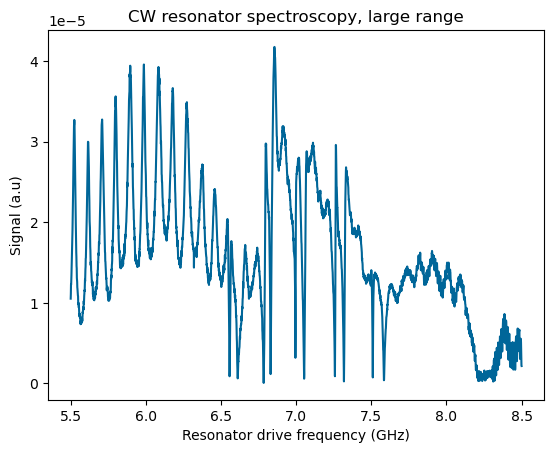

In [ ]:
# access and plot results of one 8GHz sweep
gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))

outer = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0]
inner = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[1]
full_sweep = np.array(flatten([out + inner for out in outer]))

plt.plot(full_sweep/1e9, np.array(flatten([data for data in gnd_signal])))
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, large range")

In [ ]:
save_results(demo_results_db, cw_spectroscopy_results, "cw_spec_results", "full_sweep")

# Baseband sweep CW spectroscopy

In [ ]:
single_cw = resonator_spectroscopy_single(
    transmon_list[0],
    create_freq_sweep(f"{transmon_list[0].uid}_sweep", 230e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_single_cw_spect_exp = session.compile(single_cw)
cw_spectroscopy_results = session.run(compiled_single_cw_spect_exp)
#plot_results(cw_spectroscopy_results)

2023.09.26 07:35:56.080 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:35:56.081 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:35:56.095 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:35:57.520 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:35:57.667 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:35:57.913 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:35:57.935 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:35:57.954 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.26 07:35:57.954 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.26 07:35:57.955 laboneq.compiler.workflow.co

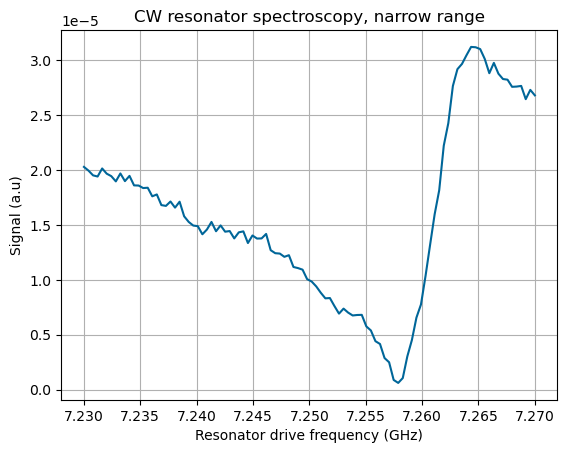

In [ ]:
lo_frequency = cw_spectroscopy_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))
full_sweep = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal)
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, narrow range")
plt.grid()

In [ ]:
#analyze_qspec(res=cw_spectroscopy_results, handle="resonator_spectroscopy_q0")

In [ ]:
first_readout_res = lo_frequency + 0.258e9
print(first_readout_res)

7258000000.0


In [ ]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = first_readout_res

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

# Spectroscopy vs Power - "Punchout" NOT TESTED


2023.09.26 07:36:00.487 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:36:00.488 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:36:00.494 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:36:01.963 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:36:02.104 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:36:02.353 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:36:02.497 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:36:02.814 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 23
2023.09.26 07:36:02.814 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8000
2023.09.26 07:36:02.814 laboneq.compiler.workflow

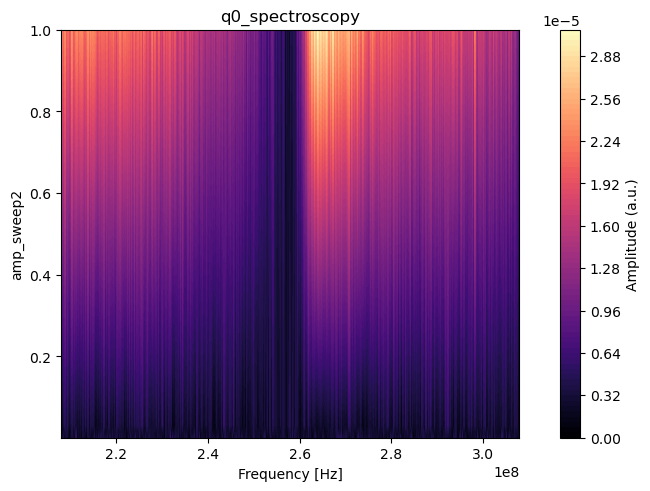

In [ ]:
if True:
    freq_upper = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        + 50e6
    )
    freq_lower = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        - 50e6
    )

    amp_sweep = SweepParameter(
        uid="amp_sweep2",
        values=np.logspace(start=np.log10(0.001), stop=np.log10(1), num=3),
    )

    punchout = res_spectroscopy_pulsed_amp_sweep(
        qubit=transmon_list[0],
        integration_kernel=integration_kernel,
        readout_pulse=readout_gauss_square_pulse,
        frequency_sweep=create_freq_sweep(
            f"{transmon_list[0].uid}_sweep", freq_lower, freq_upper, 1001
        ),
        amplitude_sweep=amp_sweep,
        num_averages=2**8,
        measure_range=-25,
        acquire_range=-5,
    )

    session.connect(do_emulation=False, reset_devices=True)
    comp_punchout = session.compile(punchout)
    punchout_result = session.run(comp_punchout)

    plot_results(punchout_result)

In [ ]:
if False:
    save_results(
        demo_results_db,
        punchout_result,
        "punchout",
        "neg_25_meas_neg_5_acq_range",
    )

In [ ]:
if False:
    qubit_parameters["multiplex_readout"]["readout_amplitude"]["value"] = 0.55

    transmon_list = update_qubit_parameters_and_calibration(
        qubit_parameters, demo_setup, demo_setup_db
    )

## Continue with your tune-up experiments:

* Qubit Spec
* Rabi
* Ramsey
* T1
* Hahn Echo

What's after that? There are many ways to go once you have done the basics:

* Drag pulse tune-up
* Single shot readout
* Active reset
* f-level tune-up
* Two qubit gates
* Tomography
* RB

# Qubit Spectroscopy

In [ ]:
def gen_const_pulse(qubit, length=5e-5,amplitude=1.0):
    return pulse_library.const(uid=f"{qubit}",length=length,amplitude=amplitude, can_compress=True)

In [ ]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=-25
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [ ]:

qubit_spec_exp = qubit_spectroscopy_single(
    qubit = transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    qubit_spectroscopy_pulse=gen_const_pulse,
    qspec_range=6e6,
    qspec_num=251,
    num_averages=2**9,
)


In [ ]:
session.connect(do_emulation=emulate,reset_devices=True)
qspec_res=session.run(qubit_spec_exp)
#plot_results(qspec_res)

2023.09.26 07:37:24.126 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:37:24.127 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:37:24.133 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:37:25.577 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:37:25.717 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:37:25.954 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:37:25.988 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:37:26.619 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 37
2023.09.26 07:37:26.619 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8064
2023.09.26 07:37:26.620 laboneq.compiler.workflow

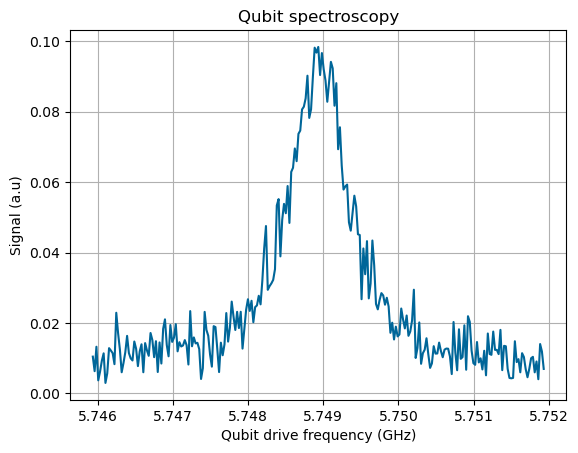

In [ ]:
lo_frequency = qubit_parameters["qubits"]["q0"]["drive_lo_frequency"]["value"]

gnd_signal = abs(qspec_res.get_data("q0_spectroscopy"))
full_sweep = qspec_res.get_axis("q0_spectroscopy")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal)
plt.xlabel("Qubit drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("Qubit spectroscopy")
plt.grid()

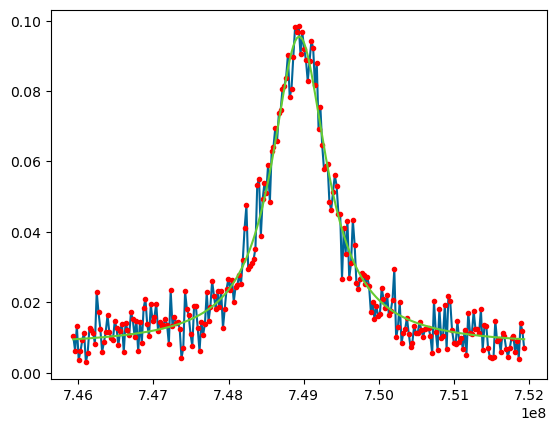

748939557.4451431


In [ ]:
qubit_resonance=analyze_qspec(qspec_res,"q0_spectroscopy",f0=7.49e8,a=0.03,gamma=1E6, flip=False)
print(qubit_resonance)

### Update qubit resonance

In [ ]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] =  qubit_parameters["qubits"]["q0"]["drive_lo_frequency"][
    "value"
] + qubit_resonance
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748939557.445143


# Amplitude Rabi

In [ ]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=10
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [ ]:
def amplitude_rabi_single(
    qubit,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    amplitude_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_rabi = Experiment(
        uid="Qubit Spectroscopy",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
            ]
        ),
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real time sweep of Rabi amplitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
                # qubit drive
                with exp_rabi.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_rabi.play(
                        signal=f"drive_{qubit.uid}",
                        pulse=drive_pulse(qubit, amplitude=1),
                        amplitude=amplitude_sweep,
                    )
                # measurement
                with exp_rabi.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_rabi.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_rabi",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
        if cal_trace:
            with exp_rabi.section(uid="cal_trace_gnd_meas"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=1e-6, # qubit.parameters.user_defined["reset_delay_length"],
                )
            with exp_rabi.section(uid="cal_trace_exc", play_after="cal_trace_gnd_meas"):
                exp_rabi.play(
                    signal=f"drive_{qubit.uid}",
                    pulse=drive_pulse(qubit, amplitude = 1),
                    amplitude = pi_amplitude,
                )
                
            with exp_rabi.section(uid="cal_trace_exc_meas", play_after="cal_trace_exc"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                )
            

    return exp_rabi

In [ ]:
amplitude_sweep=LinearSweepParameter(uid="amplitude_sweep", start=0.0, stop=0.9, count=51)


amp_rabi = amplitude_rabi_single(
    qubit=transmon_list[0],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    amplitude_sweep=amplitude_sweep,
    num_averages=2**10,
    pi_amplitude=transmon_list[0].parameters.user_defined["amplitude_pi"],
    cal_trace=True,
)

compiled_rabi = session.compile(amp_rabi)
session.connect(do_emulation=emulate, reset_devices=True)
rabi_res = session.run(compiled_rabi)


2023.09.26 07:37:48.014 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:37:48.031 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:37:48.076 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 188
2023.09.26 07:37:48.077 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8832
2023.09.26 07:37:48.077 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.26 07:37:48.078 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:37:48.079 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004


2023.09.26 07:37:48.083 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:37:49.510 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:37:49.706 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:37:50.515 laboneq.controller.controller  INFO   Starting near-time execution...
2023.09.26 07:37:50.899 laboneq.controller.controller  INFO   Estimated RT execution time: 5.44 s.
2023.09.26 07:37:56.600 laboneq.controller.controller  INFO   Finished near-time execution.


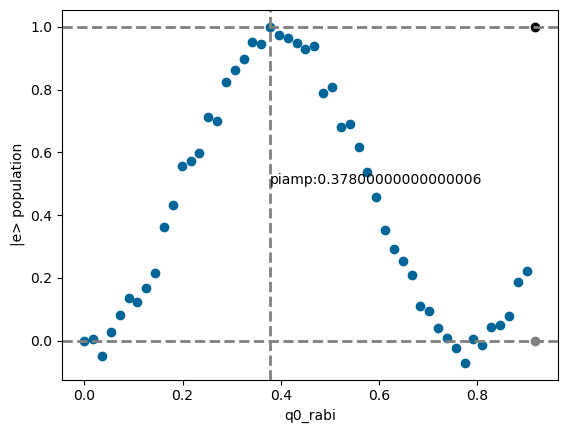

In [ ]:
plot_with_trace_rabi(rabi_res)

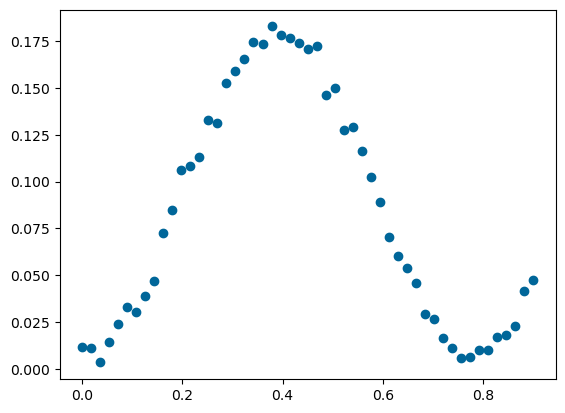

[0.08232602657235054, 1.5707963267948966, 0.08964551397873277, 0.3420000000000001]
[0.0937733  1.61896961 0.085785   0.38610123]
Pi amp: 0.39202734375000003, pi/2 amp: 0.1989998176574707


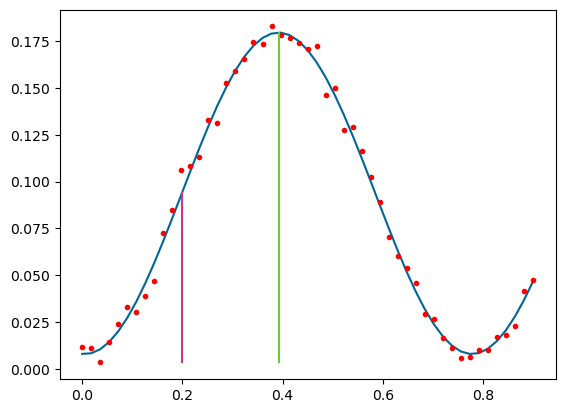

In [ ]:
[pi_amp, pi2_amp] = evaluate_rabi(rabi_res, "q0_rabi")

In [ ]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] = float(pi_amp)
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] = float(pi2_amp)


transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## T1 measurement

In [ ]:
delay_sweep=LinearSweepParameter(uid="delay_sweep", start=1e-10, stop=100e-6, count=51)

t1_meas = t1_parallel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=2**10,
)

compiled_t1 = session.compile(t1_meas)
session.connect(do_emulation=emulate, reset_devices=True)
t1_res = session.run(compiled_t1)

2023.09.26 07:37:57.261 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:37:57.272 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:37:57.310 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 313
2023.09.26 07:37:57.310 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8416
2023.09.26 07:37:57.311 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.26 07:37:57.312 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:37:57.312 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:37:57.316 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:37:58.718 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:37:58.859 laboneq.controller.devices.device

T1 found to be 17.002 us.


1.7002402190567093e-05

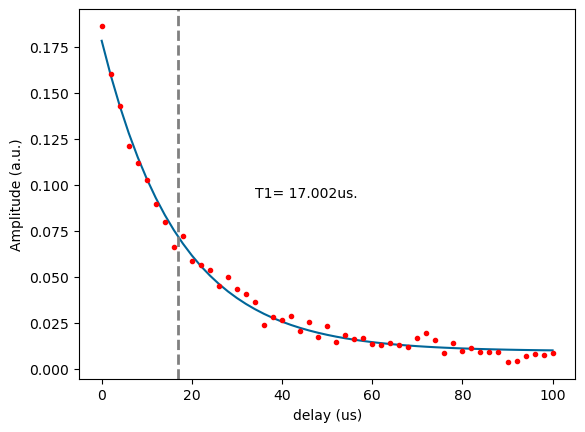

In [ ]:
evaluate_T1(t1_res, "q0_t1")

## Ramsey

In [ ]:
def ramsey_parallel(
    qubits,
    drive_pulse: callable,
    integration_kernel: callable,
    readout_pulse: callable,
    delay_sweep,
    num_averages=2**10,
    detuning = 0,
    cal_trace=False,
):
    exp_ramsey = Experiment(
        uid="Ramsey Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )


    

 #   readout_weight = readout_pulse
    freq = qubits[0].parameters.resonance_frequency_ge + detuning - qubits[0].parameters.drive_lo_frequency
  #  else:
   #     freq = detuning
         
    
    calibration = Calibration()   
    calibration["drive_q0"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq,
            modulation_type=ModulationType.HARDWARE
        )
    )

    exp_ramsey.set_calibration(calibration)

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        repetition_mode=RepetitionMode.AUTO,
    ):
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
        ):
            for qubit in qubits:
                # play qubit excitation pulse - pulse amplitude is swept
                ramsey_pulse = drive_pulse(qubit)
                with exp_ramsey.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                # readout pulse and data acquisition
                # measurement
                with exp_ramsey.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
                    
                
                if cal_trace:
                    with exp_ramsey.section(uid="cal_trace_gnd"):
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=1e-6 # qubit.parameters.user_defined["reset_delay_length"],
                        )
                    with exp_ramsey.section(uid="cal_trace_exc"):
                        exp_ramsey.play(
                            signal=f"drive_{qubit.uid}",
                            pulse=drive_pulse(qubit),
                            amplitude=qubits[0].parameters.user_defined['amplitude_pi'],
                        )
                        
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                        )

    return exp_ramsey

In [ ]:
qubit_parameters["qubits"]["q0"]["reset_delay_length"]["value"] = 100e-6
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [ ]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

### Set detuning freq

In [ ]:
detuning_freq = .3e6

In [ ]:
delay_sweep = LinearSweepParameter(uid="delay_sweep", start=0, stop=40e-6, count=151)
ramsey_exp = ramsey_parallel(transmon_list, qubit_gaussian_halfpi_pulse, integration_kernel, readout_pulse, delay_sweep, num_averages=2**10, detuning=detuning_freq, cal_trace=False)
session.connect(reset_devices=True)
compiled_exp = session.compile(ramsey_exp)
res_ramsey=session.run(compiled_exp)
#show_pulse_sheet(ramsey_exp.uid,compiled_exp)

2023.09.26 07:38:11.331 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:38:11.332 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:38:11.337 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:38:12.736 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:38:12.881 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:38:13.108 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:38:13.146 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:38:13.234 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 934
2023.09.26 07:38:13.235 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 10496
2023.09.26 07:38:13.236 laboneq.compiler.workfl

[0.10142655660506737, 1.5707963267948966, 0.08210581391691309, 3.2e-06, 1e-05]
Detuned by 0.29665980335595743 MHz; T2 found to be 17.790363012735785 us.


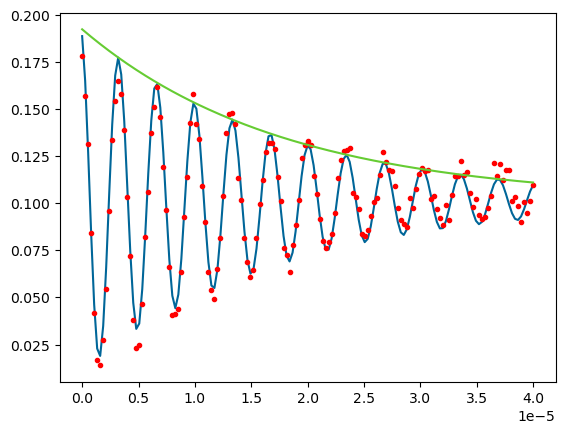

In [ ]:
[t2, detuning_freq_measured] = evaluate_ramsey(res_ramsey, 'q0_ramsey')

# Active reset

## Optimize resonance freq

In [ ]:
# resonator_spectroscopy gnd
gnd_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = None,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_g", 240e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**13,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_gnd_cw = session.compile(gnd_cw)
show_pulse_sheet("gnd_cw", compiled_gnd_cw)
gnd_cw_results = session.run(compiled_gnd_cw)

2023.09.26 07:38:36.887 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:38:36.887 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:38:36.892 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:38:38.332 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:38:38.472 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:38:38.677 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:38:38.704 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:38:38.740 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.26 07:38:38.741 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8000
2023.09.26 07:38:38.742 laboneq.compiler.workflow

In [ ]:
# resonator_spectroscopy_pi
excitation_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_e", 240e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**13,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_excitation_cw = session.compile(excitation_cw)
show_pulse_sheet("exc_cw", compiled_excitation_cw)
excitation_cw_results = session.run(compiled_excitation_cw)

2023.09.26 07:38:43.629 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 07:38:43.630 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 07:38:43.651 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 07:38:45.061 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 07:38:45.202 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 07:38:45.457 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 07:38:45.475 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 07:38:45.524 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 37
2023.09.26 07:38:45.524 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8416
2023.09.26 07:38:45.525 laboneq.compiler.workflow

## Plotting

In [ ]:
lo_frequency = gnd_cw_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(gnd_cw_results.get_data("resonator_spectroscopy_q0"))
full_sweep = gnd_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency



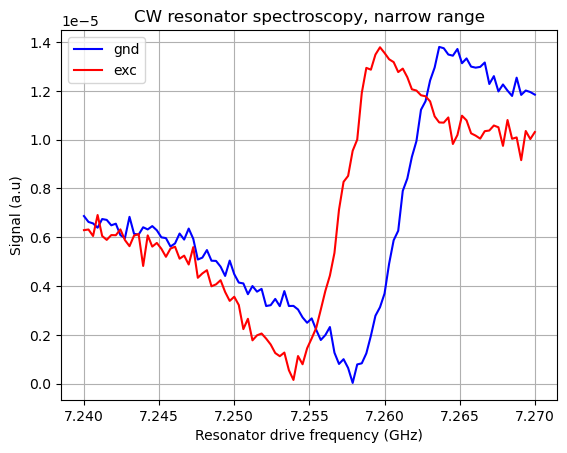

In [ ]:
lo_frequency2 = excitation_cw_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

exc_signal = abs(excitation_cw_results.get_data("resonator_spectroscopy_q0"))
full_sweep2 = excitation_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal, label="gnd",color='blue')
plt.plot(full_sweep2/1e9, exc_signal, label="exc", color='red')
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, narrow range")
plt.legend()
plt.grid()

## Optimize readout freq based on IQ distance

In [ ]:
diff_res_signal = abs(exc_signal - gnd_signal)
max_res_signal = np.max(diff_res_signal)
opt_res_freq = full_sweep[np.argmax(diff_res_signal)]
print(f"Optimized res freq {opt_res_freq/1e9} GHz gives max signal {max_res_signal}")

Optimized res freq 7.258787878787879 GHz gives max signal 1.169625403341636e-05


In [ ]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = float(opt_res_freq)

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Optimize kernels

In [34]:
def gen_exp_ref_trace(
    qubit,
    drive_pulse,
    readout_pulse,
    num_averages=2**8,
    excited=True,
):
    measure_pulse = readout_pulse(qubit)
    integration_length = measure_pulse.length + 300e-9
    print(f"integration length {integration_length}")
    exp_uid = "Exp_ref_trace_exc"
    
    exp_ref_trace = Experiment(
        uid=exp_uid,
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    
    ## define experimental sequence
    with exp_ref_trace.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        acquisition_type=AcquisitionType.RAW,
        #acquisition_type=AcquisitionType.INTEGRATION,
    ):
        if excited:
            with exp_ref_trace.section(uid="excitation"):
                exp_ref_trace.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit))
        else:
            with exp_ref_trace.section(uid="excitation"):
                exp_ref_trace.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit), amplitude=0)

        with exp_ref_trace.section(uid=f"raw_{qubit.uid}_g",play_after="excitation"):
            exp_ref_trace.play(signal=f"measure_{qubit.uid}", pulse=measure_pulse)
            exp_ref_trace.acquire(signal=f"acquire_{qubit.uid}", handle=f"raw_{qubit.uid}", length=integration_length)
            exp_ref_trace.delay(signal=f"measure_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])
            exp_ref_trace.delay(signal=f"acquire_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])

    cal = Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=None,
        port_delay=240e-9,
    )
    exp_ref_trace.set_calibration(cal)

    return exp_ref_trace

In [35]:
soft_avg = 5

gnd_ref = gen_exp_ref_trace(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_pulse,
    num_averages=2**15,
    excited=False
)
session.connect(do_emulation=False, reset_devices=True)
results_e = []
for avg in range(soft_avg):
    gnd_ref_results = session.run(gnd_ref)
    results_e.append(gnd_ref_results.get_data("raw_q0"))
show_pulse_sheet("exc_ref", gnd_ref_results.compiled_experiment)

results_g = results_e


exc_ref = gen_exp_ref_trace(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_pulse,
    num_averages=2**15,
    excited=True
)
session.connect(do_emulation=False, reset_devices=True)
results_e = []
for avg in range(soft_avg):
    exc_ref_results = session.run(exc_ref)
    results_e.append(exc_ref_results.get_data("raw_q0"))
show_pulse_sheet("exc_ref", exc_ref_results.compiled_experiment)

integration length 1.1e-06
2023.09.26 17:20:28.924 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 17:20:28.925 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 17:20:28.932 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 17:20:30.380 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 17:20:30.520 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 17:20:30.708 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 17:20:30.713 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 17:20:30.724 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 20
2023.09.26 17:20:30.725 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 2016
2023.09.26 17:20:30.72

c:\Users\ZI_at_PSI\code\Tune_up_scripts\exc_ref_2023-09-26-17-21-18.html

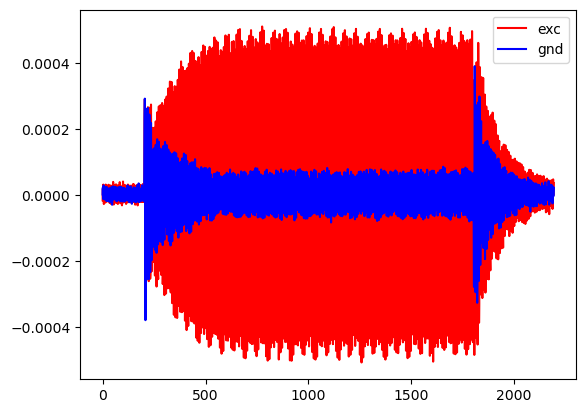

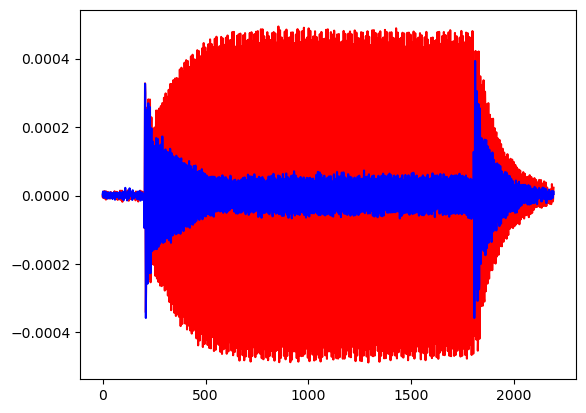

In [36]:
g_raw = np.mean(results_g, axis = 0)
e_raw = np.mean(results_e, axis = 0)

plt.plot(np.real(e_raw),c='red', label='exc')
plt.plot(np.real(g_raw),c='blue', label='gnd')
plt.legend()
plt.figure()

plt.plot(np.imag(e_raw),'r')
plt.plot(np.imag(g_raw),'b')

In [37]:
e_raw = e_raw[:-(len(e_raw)%16)]    
g_raw = g_raw[:-(len(g_raw)%16)]


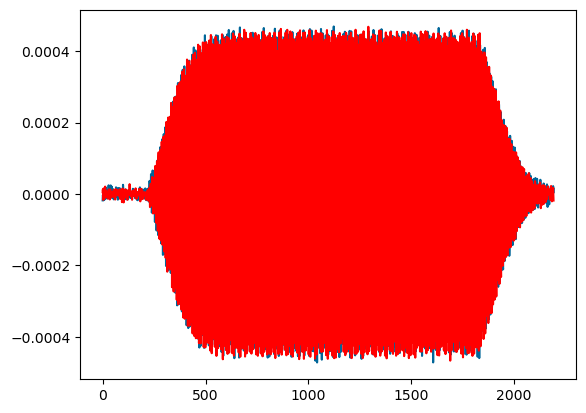

In [39]:

samples_kernel = np.conj(e_raw - g_raw)
plt.figure()
plt.plot(samples_kernel.real)
plt.plot(samples_kernel.imag)

In [40]:
def exp_int(
    qubit,
    drive_pulse,
    readout_pulse,
    integration_kernel,
    num_averages=2**8,
    use_modulated_kernel=False,
    acquisition_type=AcquisitionType.INTEGRATION,
    threshold=0.0,
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_int = Experiment(
        uid="Exp_integration",
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    measure_pulse = readout_pulse(qubit)
    print(f"measure pulse length {measure_pulse.length}")
    try:
        integration_kernel= integration_kernel(qubit)
    except Exception as e:
        print(e)
        integration_kernel = integration_kernel
    with exp_int.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        #acquisition_type=AcquisitionType.RAW,
        acquisition_type=acquisition_type,
    ):
        with exp_int.section(uid="gnd_measure"):
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=measure_pulse,
                handle=f"{qubit.uid}_int_g",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
        with exp_int.section(uid="excitation",play_after="gnd_measure"):
            exp_int.play(signal=f"drive_{qubit.uid}", pulse = drive_pulse(qubit))
        with exp_int.section(uid="exc_measure",play_after="excitation"):
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=measure_pulse,
                handle=f"{qubit.uid}_int_e",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
    if not use_modulated_kernel:
        cal = Calibration()

        cal[f"acquire_{qubit.uid}"] = SignalCalibration(
            oscillator=Oscillator(frequency=0),
            threshold=threshold
        )
        exp_int.set_calibration(cal)
    return exp_int


In [41]:
normalized_samples_kernel=samples_kernel/np.max(np.abs(samples_kernel))

In [42]:
np.abs(samples_kernel)

array([1.85518809e-05, 1.30404576e-05, 8.23615883e-06, ...,
       2.78527875e-05, 3.36465538e-06, 2.37451221e-05])

In [48]:
do_rotation = True
modulate_kernel = False
#modulate_kernel = True
rotation_angle=2.79+1.29
int_kernel = pulse_library.sampled_pulse_complex(
        normalized_samples_kernel * np.exp(1j * rotation_angle)
    )
#int_kernel = integration_kernel
my_exp = exp_int(
    transmon_list[0],
    qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    num_averages=2**10,
    use_modulated_kernel=modulate_kernel,
)
    
session.connect(do_emulation=False, reset_devices=True)
res_int = session.run(my_exp)


measure pulse length 8e-07
'PulseSampledComplex' object is not callable
2023.09.26 17:22:46.266 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 17:22:46.267 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 17:22:46.274 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 17:22:47.687 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 17:22:47.833 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 17:22:48.100 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 17:22:48.106 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 17:22:48.118 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.26 17:22:48.119 laboneq.compiler.workflow.compiler INFO   Total sample 

Using threshold = 3.520487e-01 and rotation angle: -1.216875e-01


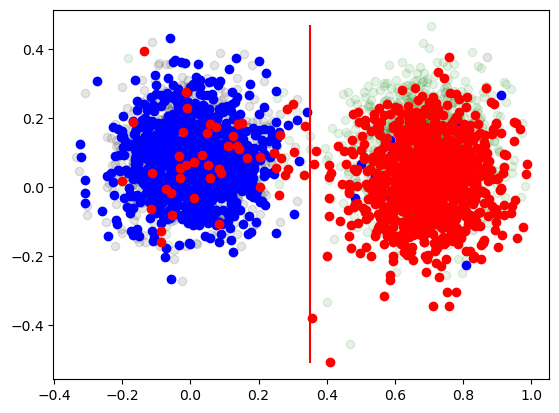

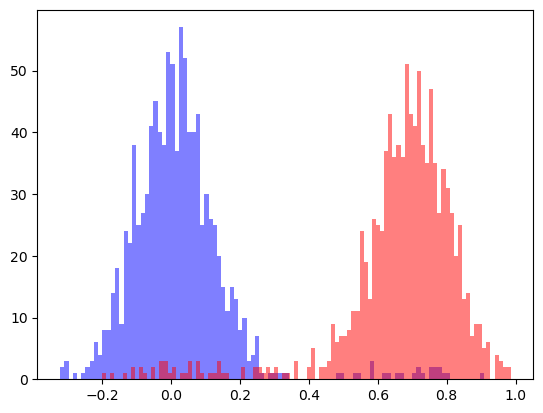

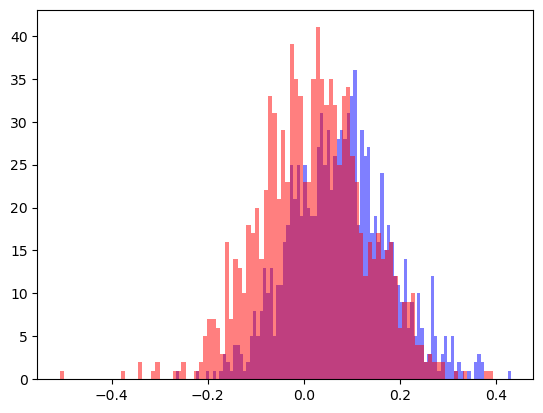

In [49]:
res0 = res_int.get_data("q0_int_g")
res1 = res_int.get_data("q0_int_e")

connect_vector = np.median(res1) - np.median(res0)
if do_rotation:
    rotation_angle = -np.angle(connect_vector)
else:
    rotation_angle = 0

res0_rot = res0 * np.exp(1j * rotation_angle)
res1_rot = res1 * np.exp(1j * rotation_angle)

my_threshold = (np.median(res0_rot.real) + np.median(res1_rot.real)) / 2

if do_rotation:
    plt.scatter(res0.real, res0.imag, c="k", alpha=0.1)
    plt.scatter(res1.real, res1.imag, c="g", alpha=0.1)

plt.scatter(res0_rot.real, res0_rot.imag, c="b")
plt.scatter(res1_rot.real, res1_rot.imag, c="r")
plt.plot(
    [my_threshold, my_threshold],
    [
        min([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
        max([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
    ],
    "r",
)
if do_rotation:
    print(f"Using threshold = {my_threshold:e} and rotation angle: {rotation_angle:e}")
else:
    print(f"Using threshold={my_threshold:e}")

plt.figure()
plt.hist(res0_rot.real, bins=100, alpha=0.5,color="blue");
plt.hist(res1_rot.real, bins=100, alpha=0.5,color="red");

plt.figure()
plt.hist(res0_rot.imag, bins=100, alpha=0.5,color="blue");
plt.hist(res1_rot.imag, bins=100, alpha=0.5,color="red");

# Calculate Fidelity

In [50]:
calculate_fidelity(res0_rot,res1_rot,my_threshold)

ee:0.9521484375
gg:0.9765625
eg:0.0478515625
ge:0.0234375
Fidelity 0.9287109375


0.9287109375

# Discrimination exp

In [51]:
disc_exp = exp_int(
    transmon_list[0],
    qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    num_averages=2**10,
    use_modulated_kernel=False,
    acquisition_type=AcquisitionType.DISCRIMINATION,
    threshold=my_threshold,
)
    
session.connect(do_emulation=False, reset_devices=True)
res_disc = session.run(disc_exp)

measure pulse length 8e-07
'PulseSampledComplex' object is not callable
2023.09.26 17:44:25.036 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 17:44:25.037 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 17:44:25.044 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 17:44:26.522 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 17:44:26.656 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 17:44:26.850 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 17:44:26.856 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 17:44:26.871 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.26 17:44:26.873 laboneq.compiler.workflow.compiler INFO   Total sample 

In [52]:
print(res_disc.acquired_results)
res_dis_q0_g=res_disc.get_data("q0_int_g")
res_dis_q0_e=res_disc.get_data("q0_int_e")
print(np.mean(res_dis_q0_g))
print(np.mean(res_dis_q0_e))

{'q0_int_g': AcquiredResult(data=array([1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]), axis_name=['shots'], axis=[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.021e+03, 1.022e+03,
       1.023e+03])], last_nt_step=[]), 'q0_int_e': AcquiredResult(data=array([1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]), axis_name=['shots'], axis=[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.021e+03, 1.022e+03,
       1.023e+03])], last_nt_step=[])}
(0.0380859375+0j)
(0.9619140625+0j)


# Active reset

In [62]:
def gen_active_reset_exp(
    qubit,
    integration_kernel,
    prepare_pulse:callable,
    pi_pulse: callable,
    readout_pulse,
    num_average=1024,
    threshold=0,
    num_rst=10,
):
    exp = Experiment(
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )

    with exp.acquire_loop_rt(
        count=num_average,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.DISCRIMINATION,
    ):

        # qubit state readout
        with exp.section(uid="prepare"):
            exp.play(signal=f"drive_{qubit.uid}", pulse=prepare_pulse(qubit),amplitude=1)

        for i in range(num_rst):
            if i==0:
                measure_playafter="prepare"
            else:
                measure_playafter=f"measure_{i-1}"
            with exp.section(uid=f"measure_{i}",play_after=measure_playafter):
                exp.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_bf_rst_{i}",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel,
                    reset_delay=100e-9,
                )
            with exp.match(
                uid=f"feedback_{i}",
                handle=f"{qubit.uid}_bf_rst_{i}",
                play_after=f"measure_{i}",
            ):
                with exp.case(state=0):
                    # play x180 pulse
                    exp.play(signal=f"drive_{qubit.uid}", pulse=pi_pulse(qubit),amplitude=0)
                with exp.case(state=1):
                    # play x180 pulse
                    exp.play(signal=f"drive_{qubit.uid}", pulse=pi_pulse(qubit),amplitude=1)
        with exp.section(uid=f"posmeasure",play_after=f"feedback_{num_rst-1}"):
            exp.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=readout_pulse(qubit),
                handle=f"{qubit.uid}_rst",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
    cal= Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=Oscillator(frequency=0),
        port_delay=240e-9,
        threshold=threshold,
    )

    exp.set_calibration(cal)

    return exp

In [65]:
reset_exp = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_drive_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=20,
)

session.connect(do_emulation=emulate, reset_devices=True)
res_reset = session.run(reset_exp)
show_pulse_sheet("reset", res_reset.compiled_experiment)
res_bf_rst = np.real(res_reset.get_data("q0_bf_rst_0"))
res_aft_rst = np.real(res_reset.get_data("q0_rst"))
print(np.count_nonzero(res_bf_rst)/len(res_bf_rst))
print(np.count_nonzero(res_aft_rst)/len(res_aft_rst))

2023.09.26 17:51:58.182 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 17:51:58.184 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 17:51:58.189 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 17:51:59.567 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 17:51:59.714 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 17:51:59.905 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 17:51:59.913 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 17:51:59.933 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 72
2023.09.26 17:51:59.935 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4624
2023.09.26 17:51:59.938 laboneq.compiler.workflow

c:\Users\ZI_at_PSI\code\Tune_up_scripts\reset_2023-09-26-17-52-01.html

# Active reset fidelity as a function of number of reset cycles

In [76]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

In [81]:
res_bf_rst=[]
res_aft_rst=[]
session.connect(do_emulation=emulate, reset_devices=True)
for n in np.arange(1,5):
    reset_exp = gen_active_reset_exp(
        qubit=transmon_list[0],
        prepare_pulse = qubit_gaussian_halfpi_pulse,
        pi_pulse=qubit_drive_pulse,
        integration_kernel=int_kernel,
        readout_pulse=readout_pulse,
        threshold=my_threshold,
        num_rst=n,
    )
    
    res_reset = session.run(reset_exp)
    bf_rst=np.real(res_reset.get_data("q0_bf_rst_0"))
    aft_rst=np.real(res_reset.get_data("q0_rst"))
    res_bf_rst.append(np.count_nonzero(bf_rst)/len(bf_rst))
    res_aft_rst.append(np.count_nonzero(aft_rst)/len(aft_rst))


2023.09.26 17:59:37.367 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.26 17:59:37.368 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.26 17:59:37.372 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.26 17:59:38.830 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.26 17:59:38.972 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.26 17:59:39.219 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.26 17:59:39.224 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.26 17:59:39.241 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 33
2023.09.26 17:59:39.244 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.09.26 17:59:39.245 laboneq.compiler.workflow

In [82]:
print(res_bf_rst)
print(res_aft_rst)

[0.5751953125, 0.55859375, 0.56640625, 0.5673828125]
[0.029296875, 0.0068359375, 0.0068359375, 0.00390625]
